## vortex panel method

In this notebook , we apply the vortex panel method to a NACA0012 airfoil in order to compute the flow field and estimate the lift. By discretizing the airfoil surface into panels with distributed vortices, we enforce the no-penetration boundary condition and compute the circulation needed to evaluate the aerodynamic lift.


In [1]:
import os
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


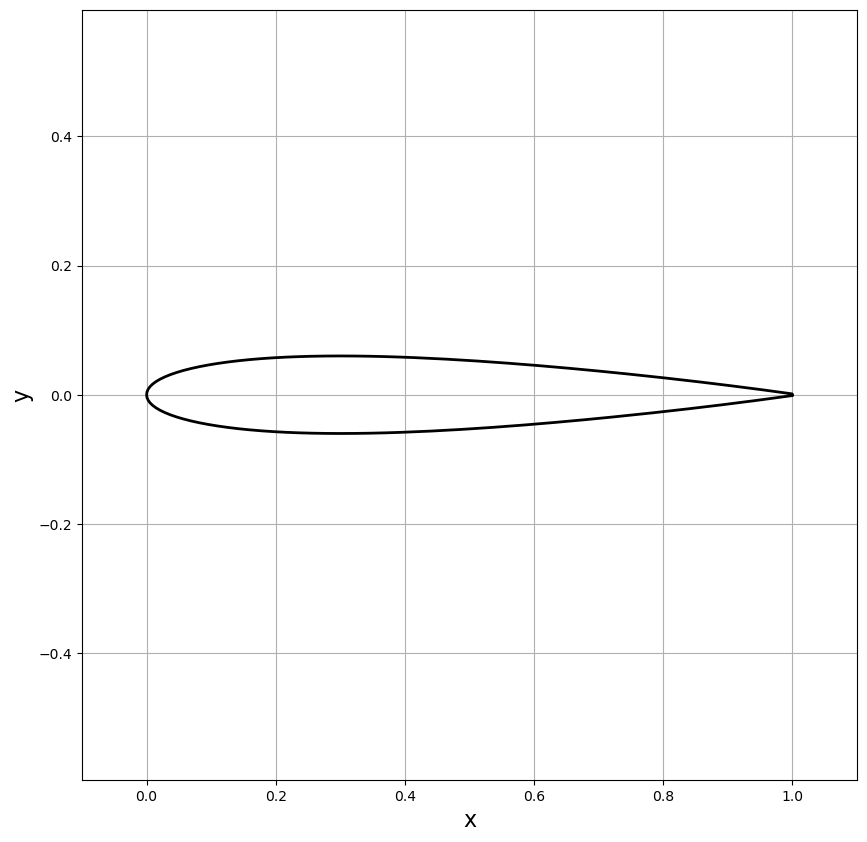

In [2]:
# read of the geometry from a data file
naca_filepath = 'naca0012.dat'
with open (naca_filepath, 'r') as file_name:
    x, y = np.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

# plot the geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

## Discretization into panels

In [3]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # control-point (center-point)
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        # location of the panel
        if self.beta <= np.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [4]:
def define_panels(x, y, N=200):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    R = (x.max() - x.min()) / 2  # radius of the circle
    x_center = (x.max() + x.min()) / 2  # x-coord of the center
    # define x-coord of the circle points
    x_circle = x_center + R * np.cos(np.linspace(0.0, 2 * np.pi, N + 1))
    
    x_ends = np.copy(x_circle)  # projection of the x-coord on the surface
    y_ends = np.empty_like(x_ends)  # initialization of the y-coord Numpy array

    x, y = np.append(x, x[0]), np.append(y, y[0])  # extend arrays using numpy.append
    
    # computes the y-coordinate of end-points
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

Now we can use this function, calling it with a desired number of panels whenever we execute the cell below. We also plot the resulting geometry.

(np.float64(-0.05),
 np.float64(1.05),
 np.float64(-0.06601892),
 np.float64(0.06601892))

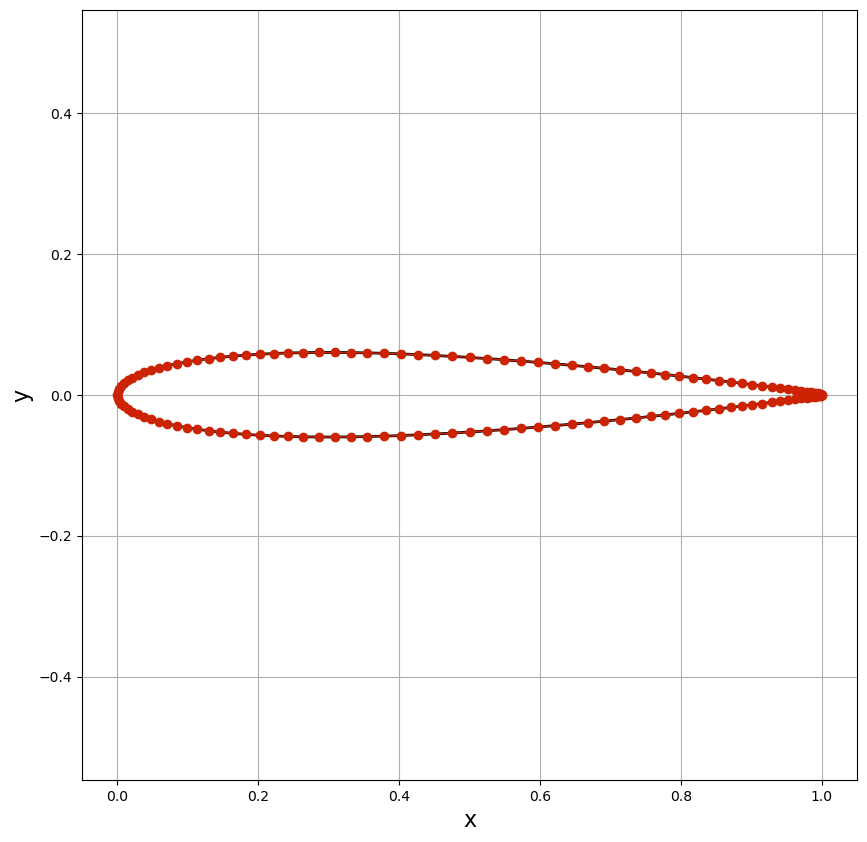

In [5]:
N = 128                          # number of panels
panels = define_panels(x, y, N)  # discretizes of the geometry into panels

# plot the geometry and the panels
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)
plt.axis('equal')


## Freestream conditions

In [6]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  # degrees --> radians

In [7]:
# define and creates the object freestream
u_inf = 1.0                            # freestream spee
alpha = 7                         # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)  # instantiation of the object freestream

## Flow tangency boundary condition
Enforcing the flow-tangency condition on each *control point* approximately makes the body geometry correspond to a dividing streamline (and the approximation improves if we represented the body with more and more panels). So, for each panel $i$, we make $u_n=0$ at $(x_{c_i},y_{c_i})$, which leads to the equation derived in the previous lesson:

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right)- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j
\end{align*}
$$

where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$.


In [8]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dydz -
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dxdz) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + np.cos(panel.beta) * s))**2))
    return integrate.quad(integrand, 0.0, panel.length)[0]


## Building the linear system
Here, we build and solve the linear system of equations of the form

$$
\begin{equation}
[A][\gamma] = [b]
\end{equation}
$$

In building the matrix, below, we call the `integral()` function with the correct values for the last parameters: $\cos \beta_i$ and $\sin\beta_i$, corresponding to a derivative in the normal direction.

Finally, we use `linalg.solve()` from NumPy to solve the system and find the strength of each panel.


In [9]:
def build_matrix(panels):
    """
    Builds the source matrix for vortex panels with Kutta condition.

    Parameters
    ----------
    panels: 1D array of Panel object
        The source panels.

    Returns
    -------
    A: 2D Numpy array of floats
        The source matrix (NxN matrix; N is the number of panels).
    """
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0)

    for i, p_i in enumerate(panels[:-1]):  # עד N-1 (האחרונה שמורה לקוטה)
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(p_i.xc, p_i.yc, p_j,
                                                 np.cos(p_i.beta),
                                                 np.sin(p_i.beta))
    A[-1, 0] = 1.0
    A[-1, -1] = 1.0
    A[-1, 1:-1] = 0.0  # ensure only γ1 + γN = 0 is applied
    return A

def build_rhs(panels, freestream):
    """
    Builds the RHS vector with Kutta condition applied in the last row.

    Parameters
    ----------
    panels : list of Panel
    freestream : Freestream

    Returns
    -------
    b : ndarray of shape (N,)
    """
    N = len(panels)
    b = np.empty(N, dtype=float)

    for i, panel in enumerate(panels[:-1]):  # עד N-1
        b[i] = freestream.u_inf * np.cos(freestream.alpha - panel.beta)

    b[-1] = 0.0  # תנאי קוטה

    return b

In [10]:
A = build_matrix(panels)           # compute the influence matrix for vortex panels
b = build_rhs(panels, freestream)  # compute the freestream RHS (includes Kutta if needed)
# solve the linear system
gamma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.gamma = gamma[i]         # store the vortex strength on each panel


### Lift Coefficient from the Kutta–Joukowski Theorem

From the **Kutta–Joukowski theorem**, the lift coefficient for the vortex panel method is given by:

$$
C_L = \frac{2\Gamma}{U_\infty c}
$$

where:

- $\Gamma$ is the **total circulation** around the airfoil, computed as the sum of all vortex strengths times their respective panel lengths:

$$
\Gamma = \sum_{j=1}^N \gamma_j \Delta s_j
$$

- $c$ is the **chord length** of the airfoil  
- $U_\infty$ is the **freestream velocity**

> The circulation is considered **positive for clockwise rotation** around the airfoil, consistent with the panel definition.

---

In [11]:
# Calculate the total circulation
gamma_total = sum(panel.gamma * panel.length for panel in panels)

# Compute chord length (assuming trailing edge - leading edge in x)
chord = max(panel.xb for panel in panels) - min(panel.xa for panel in panels)

# Compute the lift coefficient using Kutta–Joukowski theorem
cl = 2 * gamma_total / (freestream.u_inf * chord)

print(f"Lift Coefficient (C_L): {cl:.4f}")

Lift Coefficient (C_L): 0.8485


In [ ]:
alpha_range = np.linspace(0, 12, 25)  # זוויות התקפה במעלות
cl_values = []

for alpha_deg in alpha_range:
    freestream = Freestream(u_inf=1.0, alpha=alpha_deg)  # נניח שהמרה לרדיאנים בפנים

    A = build_matrix(panels)
    b = build_rhs(panels, freestream)
    gamma = np.linalg.solve(A, b)

    for i, panel in enumerate(panels):
        panel.gamma = gamma[i]

    gamma_total = sum(panel.gamma * panel.length for panel in panels)
    chord = max(panel.xb for panel in panels) - min(panel.xa for panel in panels)
    cl = 2 * gamma_total / (freestream.u_inf * chord)
    cl_values.append(cl)

# חישוב ערך תאורטי לפי תורת הכנף הדקה
alpha_rad = np.radians(alpha_range)  # נדרש לרדיאנים עבור הקו התאורטי
cl_theory = 2 * np.pi * alpha_rad

# ציור גרף
plt.figure(figsize=(8, 5))
plt.plot(alpha_range, cl_values, marker='o', label='Vortex Panel Method')
plt.plot(alpha_range, cl_theory, linestyle='--', label='Thin Airfoil Theory', color='r')
plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel(r'$C_L$', fontsize=14)
plt.title('Lift Coefficient vs Angle of Attack', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(type(x_start), type(gamma))
